<a href="https://colab.research.google.com/github/ysau/PIML/blob/main/one_dimensional_harmonics_oscillator_inverse_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1D Harmonics Oscillator: Inverse Problem

## Problem Statement
In this notebook [[link]](https://colab.research.google.com/github/ysau/PIML/blob/main/one_dimensional_harmonics_oscillator_forward_problem.ipynb), we solved the forward problem using both physics-based loss and data loss. In many cases, the governing differential equations are known, but the exact values of their parameters are not. In this notebook, we focus on fitting those unknown parameters to observed data.

Governing equation:

$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0
$$

where $m$, $\mu$, and $k$ are unknown.

We will solve the inverse problem in the under-damped case:

$$
\delta < \omega_0~,~~~~\mathrm{where}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}
$$

In [52]:
#@title Setup Codes
!pip install torchview

from PIL import Image as PILImage
from IPython.display import display, Image as DisplayImage

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from enum import Enum, auto
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchview import draw_graph

# Problem Constants
# Physics constants
DELTA = 2
W0 = 20
X_MIN = 0
X_MAX = 1
# Training constants
NUM_TRAIN_POINTS = 30
NUM_TRAIN_STEPS = 80000
LEARNING_RATE = 1e-4
PHYSICS_SCLAE = 1e-4
LOG_EVERY = 150
SHOW_EVERY = 6000


def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem.
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    d = torch.tensor(d, dtype=torch.float32) # Convert d to torch tensor
    w0 = torch.tensor(w0, dtype=torch.float32) # Convert w0 to torch tensor
    w = torch.sqrt(w0**2 - d**2) # Convert w to torch tensor
    phi = torch.arctan(-d / w) # Convert phi to torch tensor
    A = 1 / (2 * torch.cos(phi))
    cos = torch.cos(phi + w * x)
    sin = torch.sin(phi + w * x)
    exp = torch.exp(-d * x)
    y = exp * 2 * A * cos
    return y


class FCN(nn.Module):
    "Defines a connected network"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        self.fch = nn.Sequential(
            *[
                nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()])
                for _ in range(N_LAYERS - 1)
            ]
        )
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

        # Initialize hidden layers
        first_linear = self.fcs[0]
        torch.nn.init.xavier_normal_(
            first_linear.weight, gain=nn.init.calculate_gain("tanh")
        )
        nn.init.zeros_(first_linear.bias)
        for block in self.fch:
            linear = block[0]
            torch.nn.init.xavier_normal_(
                linear.weight, gain=nn.init.calculate_gain("tanh")
            )
            nn.init.zeros_(linear.bias)
        # Final layer: small random weights + bias in (0.25, 0.75)
        nn.init.xavier_normal_(self.fce.weight, gain=1.0)
        nn.init.normal_(self.fce.bias, 0.25, 0.5)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

class InversePINN(nn.Module):
  def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS, delta_init=1.5, w0_init=15.0):
    super().__init__()
    self.solution_network = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)
    # delta and w0 are global learnable parameters
    self.delta = nn.Parameter(torch.tensor(delta_init))
    self.w0 = nn.Parameter(torch.tensor(w0_init))

  def forward(self, x):
    return self.solution_network(x)

  def get_physics_parameters(self):
    # Enforce constraint: delta < w0
    delta_constraint = torch.clamp(self.delta, max=self.w0 - 0.1)
    return delta_constraint, self.w0

  def get_solution_parameters(self):
    self.delta, self.w0 = self.get_physics_parameters()
    return self.delta, self.w0

  def get_w0(self):
    return self.w0

def generate_train_data(delta, w0, num_points, x_min=0, x_max=1):
    x = (
        torch.linspace(x_min, x_max, num_points)
        .view(-1, 1)
        .detach()
        .requires_grad_(True)
    )
    y = oscillator(delta, w0, x).view(-1, 1).clone().detach().requires_grad_(True)
    return x, y


def plot_result(x, y, x_data, y_data, yh, xp=None, step=0, title="PINN Results"):
    "Pretty plot training results"
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(
        x,
        yh,
        color="tab:blue",
        linewidth=4,
        alpha=0.8,
        label="Neural network prediction",
    )
    plt.scatter(
        x_data, y_data, s=60, color="tab:orange", alpha=0.4, label="Training data"
    )
    if xp is not None:
        plt.scatter(
            xp,
            -0 * torch.ones_like(xp),
            s=60,
            color="tab:green",
            alpha=0.4,
            label="Physics loss training locations",
        )
    l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(
        1.065, 0.7, "Training step: %step" % (step + 1), fontsize="xx-large", color="k"
    )
    plt.title(title, fontsize="xx-large")
    plt.axis("off")


def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [PILImage.open(file) for file in files]
    imgs[0].save(
        fp=outfile,
        format="GIF",
        append_images=imgs[1:],
        save_all=True,
        duration=int(1000 / fps),
        loop=loop,
    )



def train(
    delta,
    w0,
    num_train_points,
    num_train_steps
):
    x_train, y_train = generate_train_data(
            delta, w0, num_points=num_train_points, x_min=X_MIN, x_max=X_MAX
        )
    x_physics, _ = generate_train_data(
            delta, w0, num_points=num_train_points, x_min=X_MIN, x_max=X_MAX
        )

    # Full-domain resolution for plotting
    x_ref = torch.linspace(0, 1, 1000).view(-1, 1)
    y_ref = oscillator(delta, w0, x_ref)

    torch.manual_seed(123)
    model = InversePINN(1, 1, 32, 3)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    plot_files = []

    for step in range(1, num_train_steps + 1):
        optimizer.zero_grad()

        # compute the "physics loss"
        y_hat_phys = model(x_physics)
        dy_dx_phys = torch.autograd.grad(
        y_hat_phys.sum(), x_physics, create_graph=True
            )[0]
        d2y_d2x_phys = torch.autograd.grad(
                dy_dx_phys.sum(), x_physics, create_graph=True
            )[0]
        delta_guess, w0_guess = model.get_physics_parameters()
        mu, k = 2 * delta_guess, w0_guess**2
        residual = d2y_d2x_phys + mu * dy_dx_phys + k * y_hat_phys
        physics_loss = PHYSICS_SCLAE * residual.pow(2).mean()

        # compute the "data loss"
        y_hat_data = model(x_train)
        data_loss = (y_hat_data - y_train).pow(2).mean()
        loss = physics_loss + data_loss

        loss.backward()
        optimizer.step()

        # plot the result as training progresses
        if step % LOG_EVERY == 0:
            with torch.no_grad():
                y_hat_ref = model(x_ref)
                plot_title = f"Physics + Data Loss\n delta = {delta_guess.item():.2f}, w0 = {w0_guess.item():.2f}"
                fname = f"pinn_physics_data_{step:08d}.png"
                plot_result(
                    x_ref,
                    y_ref,
                    x_train.detach()[:num_train_points],
                    y_train.detach()[:num_train_points],
                    y_hat_ref.detach(),
                    x_physics.detach()[:num_train_points],
                    step,
                    title=plot_title,
                )
                plt.savefig(
                    fname,
                    bbox_inches="tight",
                    pad_inches=0.1,
                    dpi=100,
                    facecolor="white",
                )
                plot_files.append(fname)
                if (step + 1) % SHOW_EVERY == 0:
                    plt.show()
                else:
                    plt.close("all")
    try:
        fname = "pinn_physics_data.gif"
        save_gif_PIL(fname, plot_files, fps=20, loop=0)
        display(DisplayImage(filename=fname))
    except Exception as e:
        print(f"GIF creation skipped: {e}")


def check_gpu():
    if torch.cuda.is_available():
        print(f"{torch.cuda.device_count()} GPU(s) are available")
    else:
        print("GPU is not available. Using CPU")

In [53]:
#@title Check Compute Resource
check_gpu()

1 GPU(s) are available


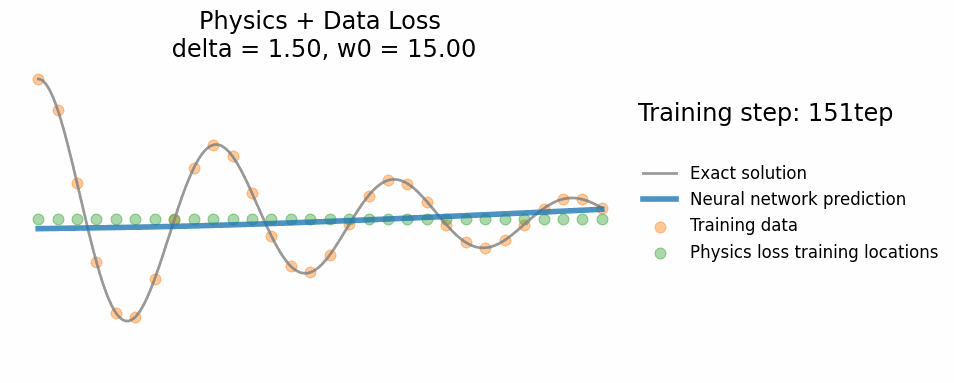

In [54]:
#@title Training using Physics + Data Loss
train(DELTA, W0, NUM_TRAIN_POINTS, NUM_TRAIN_STEPS)